# Harpia Anaylsis
For analysing data from Harpia 1 or 2. Most functions are for the exported data from the CarpetView program but some are for the raw files from measurement - check in the code source file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from HARPIA_Analysis_Functions import *

HARPIA_Analysis_Functions is the file containing relevant analysis functions for ns TA measured on the Harpia.

Diagnostic Checks:
To check the stability of the Picolo pump during the measurement, call 'extract_pump_values(filename)' where the file is a pre-Carpetview .dat file.

Analysis:
Call 'plot_spectrum(filename, times = [1,2,etc] wls = [low, high], mOD=False)' where filename is the CarpetView-exported .dat file, the times are the timepoints you want to look at, wls are the bounds of the spectral region and the mOD is whether you are keeping it in units of mOD or converting to DT/T. I may ammend this if i do the conversion in Carpetview more often than not.


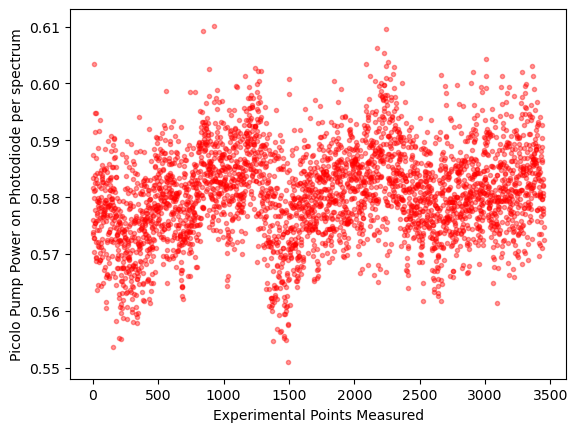

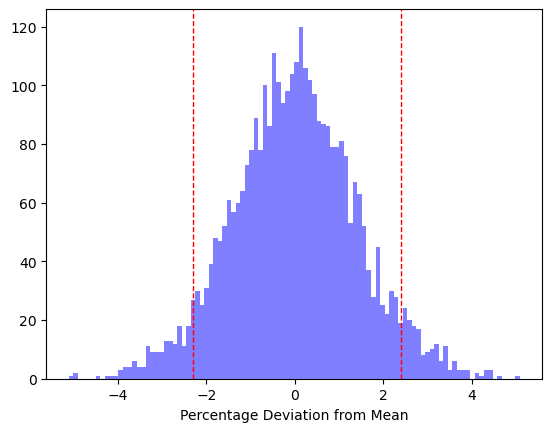

['NP_20_D90_10us.dat', 'NP_23_D95_10us.dat', 'NP_26_D127_10us.dat', 'NP_29_D117_10us.dat']


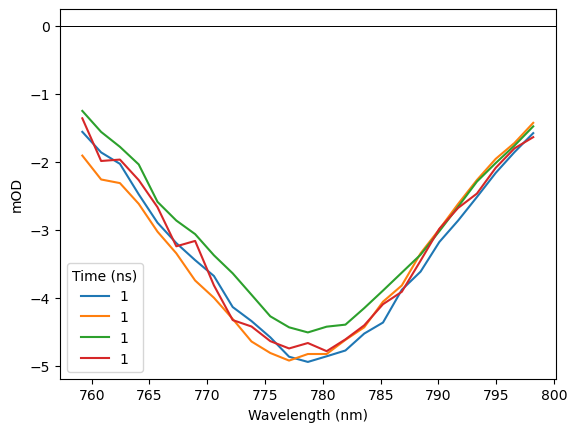

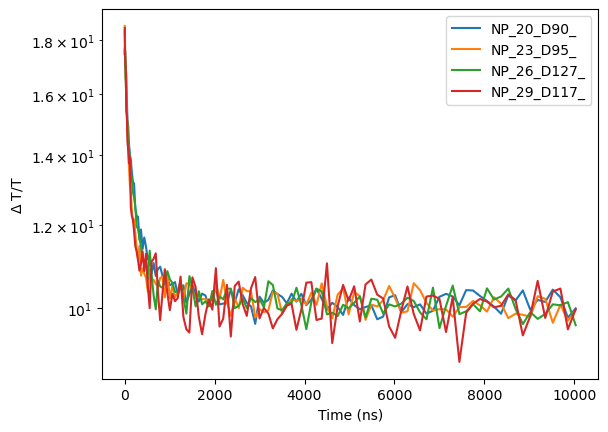

In [8]:
files = [f for f in os.listdir() if f.endswith('.dat') and '10us' in f and 'Weidong' not in f]


file = 'Weidong_HighMIFacets_D95_60uW20240514_18_36_52.dat'

extract_pump_values(file)
print(files)
for f in files:
    plot_spectrum(f, times = [1], mOD=True, wls=[760,800])
plt.show()
bleach_decays = []
for f in files:
    bleach_decays.append(plot_bleach(f, label = f[:-8], mOD=False,constant=10))
plt.show()

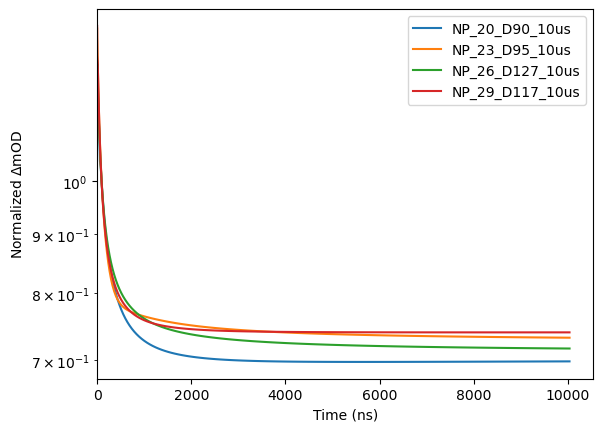

In [3]:
def fit_complex(x,a,b,c,d,e,f,g,h,i,j,C):
    return C+(f+g*x+h*x**2+i*x**3+j*x**4)/(a+b*x+c*x**2+d*x**3+e*x**4)

from scipy.optimize import curve_fit
def fit_bleach(bleach):
    popt, pcov = curve_fit(fit_complex, bleach[0], bleach[1], p0 = [1,1,1,1,1,1,1,1,1,1,1], maxfev = 100000)
    return popt
  
    
fits = []

for bleach,file in zip(bleach_decays,files):
    popt = fit_bleach(bleach)
    plt.plot(bleach[0], fit_complex(bleach[0], *popt))
    plt.plot(bleach[0], bleach[1],'.')
    plt.xscale('log')
    fits.append(np.array([bleach[0],fit_complex(bleach[0], *popt)]))
    plt.title(file[:-8])
    plt.ylabel('$\Delta$mOD')
    plt.xlabel('Time (ns)')
    plt.close()
    
for fit, file in zip(fits,files):
    time = fit[0]
    signal = fit[1]
    time = time[signal.argmax():]- time[signal.argmax()]
    signal = signal[signal.argmax():]
    #find index of closest to 100 ns
    time100 = np.argmin(np.abs(time-100))
    # print(time100)
    plt.plot(time,signal/signal[time100],label = file[:-4])
    plt.legend()
    plt.ylabel('Normalized $\Delta$mOD')
    plt.xlabel('Time (ns)')
    plt.yscale('log')
    #plt.xscale('log')
    plt.xlim(0,)

In [4]:
pump_diameter = 763.5e-4
area = np.pi*(pump_diameter/2)**2
wavelength = 532e-9
hv = 6.626e-34*3e8/wavelength
power = 60e-6

absorption = 1
thickness = 1e-4
reprate = 5e3
p_fluence = power/(area)
e_fluence = p_fluence/reprate
carrier_density = (absorption*power)/(hv*reprate*thickness*area)
print(carrier_density)
print(f'\nArea = {area:.2e} cm^-2 \nCarrier Density = {carrier_density:.2e} cm-3 \nPower Fluence = {int(p_fluence/1e-3)} uWcm-2, \nEnergy Fluence = {e_fluence/1e-6:.2e} uJcm-2')

7.0147504876128056e+16

Area = 4.58e-03 cm^-2 
Carrier Density = 7.01e+16 cm-3 
Power Fluence = 13 uWcm-2, 
Energy Fluence = 2.62e+00 uJcm-2


[1.54316914e+16 1.32566400e-03 2.36925800e-19 3.86601158e+16]


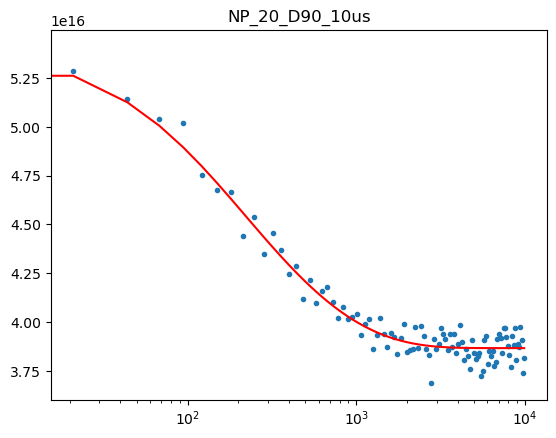

[ 1.37842669e+16 -2.22591145e-07  6.41572529e-19  3.78092178e+16]


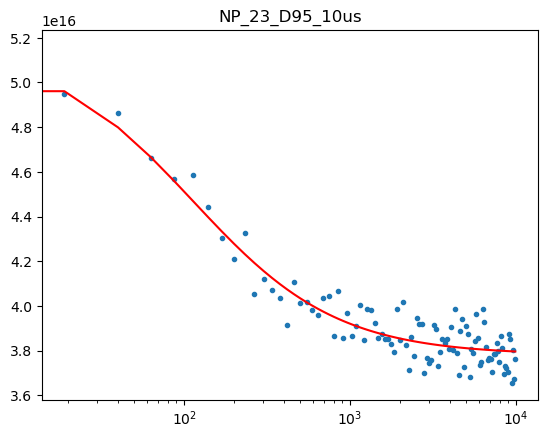

[ 2.09151166e+16 -1.21734787e-03  3.11138705e-19  3.60605933e+16]


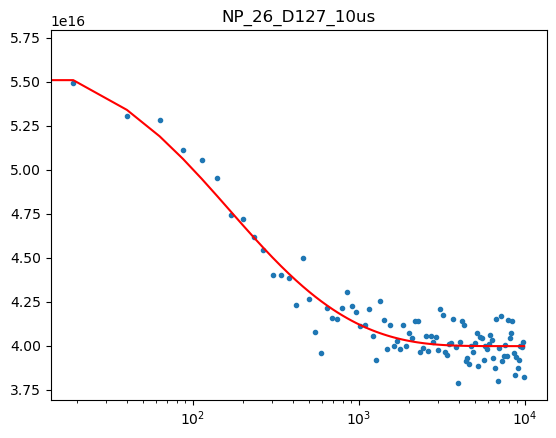

[ 1.42025665e+16 -5.58821310e-04  7.19566159e-19  3.72206388e+16]


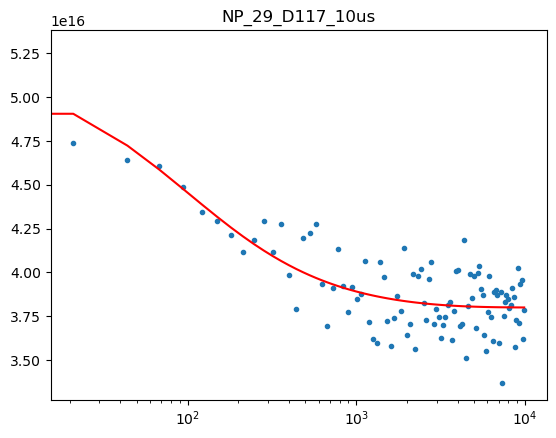

,Filename,n0,A,B,Background
0,NP_20_D90_,1.54e+16,1.33e-03,2.37e-19,3.87e+16
1,NP_23_D95_,1.38e+16,-2.23e-07,6.42e-19,3.78e+16
2,NP_26_D127_,2.09e+16,-1.22e-03,3.11e-19,3.61e+16
3,NP_29_D117_,1.42e+16,-5.59e-04,7.20e-19,3.72e+16


In [5]:
def fit_AB(t, n0, A, B,C):
    return (n0 * A / (n0 * B * (np.exp(A * t) - 1) + A * np.exp(A * t)))+C

t_start = 10

# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['n0', 'A', 'B','Background'])

for bleach, file in zip(bleach_decays, files):
    time = bleach[0][t_start:] - bleach[0][t_start]
    
    signal =  carrier_density*(bleach[1] / bleach[1][0])
    signal = signal[t_start:]

    popt, pcov = curve_fit(fit_AB, time, signal, p0=[signal[0], 1e-4, 1e-19,1e16], 
                           
                           maxfev=100000)
    print(popt)
    
    plt.plot(time, signal, '.')
    plt.plot(time, fit_AB(time, *popt), 'r')
    plt.title(file[:-4])
    plt.xscale('log')
    plt.show()
    
    # Create a temporary DataFrame with the results
    temp_df = pd.DataFrame([popt], columns=['n0', 'A', 'B','Background'], index=[file[:-8]])
    
    # Append the temporary DataFrame to the main DataFrame
    results_df = pd.concat([results_df, temp_df])

# Reset the index to ensure it is properly formatted
results_df = results_df.reset_index().rename(columns={'index': 'Filename'})

# Format DataFrame values in scientific notation to 1 decimal place
pd.options.display.float_format = '{:.2e}'.format
results_df

In [6]:
def fit_exp(t, n0, A, C):
    return n0 * np.exp(-A * t) + C

# List of start times
start_times = range(10, 90)  # Example list of start times from 30 to 49

# Dictionary to hold DataFrames for each bleach decay
results_dict = {}

for bleach, file in zip(bleach_decays, files):
    # Initialize an empty DataFrame for this file
    file_results_df = pd.DataFrame(columns=['Start_Time', 'n0', 'A', 'C'])
    
    for t_start in start_times:
        if t_start >= len(bleach[0]):
            continue

        time = bleach[0][t_start:] - bleach[0][t_start]
        signal = bleach[1]
        signal = carrier_density * signal / signal[0]
        signal = bleach[1][t_start:]
        time_plot = bleach[0][t_start:]
        
        try:
            popt, pcov = curve_fit(fit_exp, time, signal, p0=[signal[0], 1e-4, 0.5e16], maxfev=100000)
            print(f"Start time: {t_start}, Params: {popt}")
            
            plt.plot(time_plot, signal, '.')
            plt.plot(time_plot, fit_exp(time, *popt), 'r')
            plt.title(f"{file[:-4]} (Start Time: {t_start})")
            #plt.xscale('log')
            plt.close()
            
            # Append the results to the DataFrame
            temp_df = pd.DataFrame([[time_plot[0], *popt]], columns=['Start_Time', 'n0', 'A', 'C'])
            file_results_df = pd.concat([file_results_df, temp_df], ignore_index=True)
        
        except RuntimeError as e:
            print(f"Fit did not converge for start time {t_start}: {e}")
            continue
    
    # Add the DataFrame to the results dictionary
    results_dict[file[:-8]] = file_results_df

# Format DataFrame values in scientific notation to 2 decimal places
pd.options.display.float_format = '{:.2e}'.format

# Save all DataFrames to the same Excel file with different sheets
with pd.ExcelWriter('10usresults.xlsx') as writer:
    for filename, df in results_dict.items():
        df.to_excel(writer, sheet_name=filename, index=False)

# Optionally, print results for each file
for filename, df in results_dict.items():
    print(f"Results for {filename}:")
    print(df)




Start time: 10, Params: [3.68904433e+00 3.05187792e-03 1.01662073e+01]
Start time: 11, Params: [3.40596550e+00 2.97635252e-03 1.01639558e+01]
Start time: 12, Params: [3.07697540e+00 2.82294097e-03 1.01595013e+01]
Start time: 13, Params: [2.78796823e+00 2.68781549e-03 1.01556609e+01]
Start time: 14, Params: [2.50650240e+00 2.53675594e-03 1.01514520e+01]
Start time: 15, Params: [2.17105214e+00 2.25835360e-03 1.01437269e+01]
Start time: 16, Params: [-5.43280059e+03 -1.77211351e-08  5.44353306e+03]
Start time: 17, Params: [-5.15182014e+03 -1.72791169e-08  5.16250630e+03]
Start time: 18, Params: [-5.02875275e+03 -1.62134480e-08  5.03939145e+03]
Start time: 19, Params: [-5.35422574e+03 -1.43083133e-08  5.36483239e+03]
Start time: 20, Params: [-4.13524357e+03 -1.69540461e-08  4.14580896e+03]
Start time: 21, Params: [-3.17858830e+03 -2.07122885e-08  3.18912584e+03]
Start time: 22, Params: [-2.91787856e+03 -2.04870440e-08  2.92837788e+03]
Start time: 23, Params: [-3.22906362e+03 -1.69237811e-08

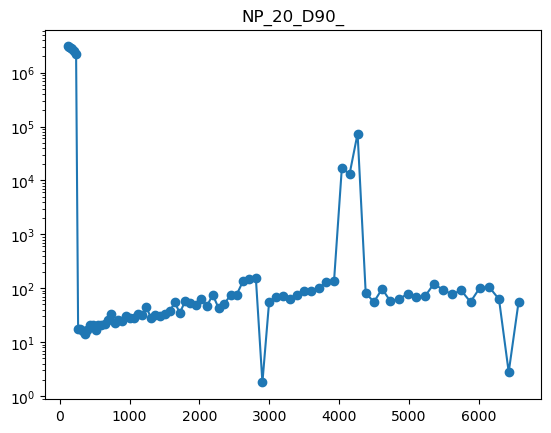

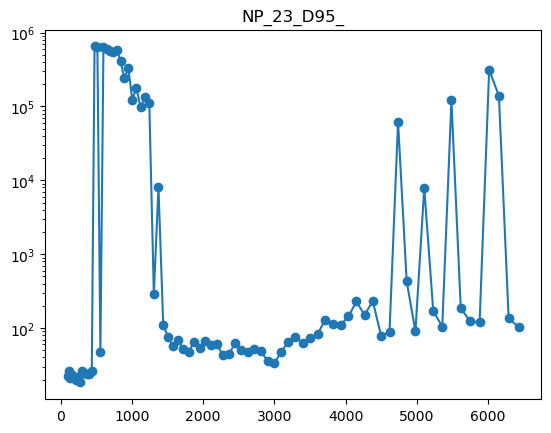

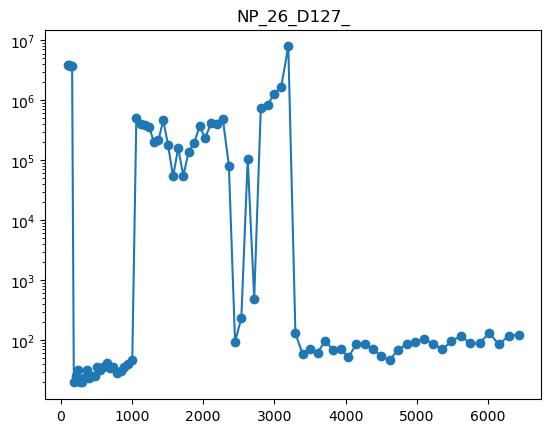

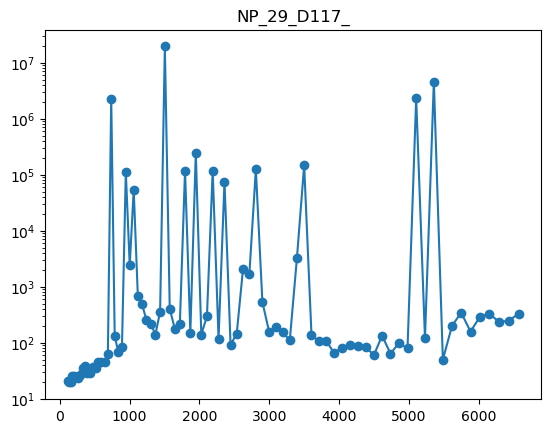

In [7]:
#Plot start time vs A for each of the files
for filename, df in results_dict.items():
    plt.plot(df['Start_Time'], abs(df['A'])*1e9, 'o-', label=filename)
    plt.yscale('log')
    plt.title(filename)
    plt.show()
    